# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from sklearn.neighbors import NearestNeighbors

In [4]:
def detect_stars(image, treshold=5):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a binary image
    _, binary_image = cv2.threshold(gray_image, 40, 255, 0)

    blob_extraction_image = image.copy()
    # Detect connected components (blobs) in the binary image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary_image
    )
    center_points = []
    # Loop through the detected blobs and draw a circle on the output image
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > treshold:
            # Get the centroid of the blob
            center = tuple(map(int, centroids[i]))
            center_points.append(center)
            # Find the minimum enclosing circle of the blob
            radius, _ = cv2.minEnclosingCircle(np.argwhere(labels == i))
            # Draw the circle on the output image
            blob_extraction_image = cv2.circle(
                blob_extraction_image, center, 20, (0, 255, 0), 1
            )
    return np.array(center_points), blob_extraction_image

def get_rotation_and_translation(X, Y):
    # Step 1: Compute mean
    mean_x = np.mean(X, axis=0)
    mean_y = np.mean(Y, axis=0)

    # Step 2: Center points at the origin
    centered_x = X - mean_x
    centered_y = Y - mean_y

    # Step 3: Compute covariance
    covarience = (centered_y.T @ centered_x) / (X.shape[0])

    # Step 4: Use SVD to represent the covariance matrix as rotations and stretching matrices
    U, _, Vt = np.linalg.svd(covarience, full_matrices=False)

    # Step 5: Remove the stretching matrix to obtain the final rotation matrix
    R = U @ Vt

    # Check for mirroring
    if np.linalg.det(R) < 0:
        # Mirror the matrix
        Vt[-1, :] *= -1
        R = U @ Vt

    # Step 6: Compute optimal translation vector
    t = mean_y - R @ mean_x

    return R, t


def transform_image(Y, t, R):
    # Get image dimensions
    height, width = Y.shape[:2]

    # Define the transformation matrix
    M = np.zeros((2, 3))
    M[:2, :2] = R
    M[:2, 2] = t

    # Perform the image transformation
    transformed_image = cv2.warpAffine(Y, M, (width, height))

    return transformed_image


def get_ssd(X, Y):
    # Ensure X and Y have the same shape
    assert X.shape == Y.shape, "Matrices must have the same shape."

    # Compute element-wise squared differences
    squared_diff = np.square(X - Y)

    # Sum up the squared differences
    ssd = np.sum(squared_diff)

    return ssd

def iterative_closest_points(
    X, Y, image_X, image_Y, tolerance=1, threshold=2, plot=True, verbose=True
):
    current_ssd = 0
    previous_ssd = np.inf
    iteration = 1

    # Loop continues until convergence
    while abs(current_ssd - previous_ssd) > tolerance:
        # Step 1: Establish correspondences using nearest neighbor
        nearest_neighbors = NearestNeighbors(n_neighbors=1).fit(X)
        distances, indexes = nearest_neighbors.kneighbors(Y, return_distance=True)

        # To avoid duplicates, in case of multiple points y ∈ Y corresponding to a
        # single point x ∈ X keep only the closest point to x.
        distances_df = pd.DataFrame(
            data=np.hstack((indexes, distances)), columns=["indexes", "distances"]
        )
        min_distances_df = distances_df.groupby(["indexes"]).agg("min").reset_index()
        distances_df = (
            distances_df.reset_index()
            .merge(min_distances_df, on=["indexes", "distances"])
            .set_index("index")
        )

        # Remove outlier points using Z-score method
        closest_distances = distances_df["distances"].values
        z_scores = np.abs(
            (closest_distances - np.mean(closest_distances)) / np.std(closest_distances)
        )
        distances_df = distances_df[z_scores < threshold]

        X_indexes = distances_df["indexes"].values.astype("int")
        Y_indexes = distances_df.index

        X_corresponding_points = X[X_indexes]
        Y_closest_points = Y[Y_indexes]

        # Step 2: Estimate rotation and translation
        R, t = get_rotation_and_translation(X_corresponding_points, Y_closest_points)

        # Compute Sum of Squared Distances
        ssd = get_ssd(X_corresponding_points, Y_closest_points) / X_corresponding_points.shape[0]
        previous_ssd = current_ssd
        current_ssd = ssd
        if verbose:
            print("Sum of Squared Differences: ", ssd)

        # Step 3: Apply the obtained rotation and translation to the points and the image
        Y = (Y - t) @ R
        image_Y = transform_image(image_Y, -t, R.T)

        iteration += 1

    return Y, image_Y

## Image Stacking

One of the most significant sources of noise in astrophotography is shot noise, a type of noise inherent in all digital images associated with the particle nature of light. To better understand shot noise one can think of rain falling on a small surface, light rain will leave a spotted pattern until enough rain drops have fallen to make the surface uniformly wet, while heavy rain, will immediately wet the surface. The same idea applies for photons "falling" on the camera sensor.

The signal-to-noise ratio (SNR) equals the signal's square root for shot noise: 
$$SNR = \sqrt{N}$$
Put simply, the more photons we have, the better the SNR and vice versa.

To reduce the noise, multiple images of the same scene can be combined into a single image using a technique called Image Stacking. By removing random variations, this process improves the signal-to-noise ratio, enhancing details and faint structures captured in individual frames.

In [ ]:
def stack_images(moving_images, reference_image, stacking_mode='mean'):

    reference_point_cloud, _ = detect_stars(reference_image)
    aligned_images = []


    for moving_image in moving_images:
        moving_point_cloud, _ = detect_stars(moving_image)

        _, aligned_image = iterative_closest_points(
            reference_point_cloud,
            moving_point_cloud,
            reference_image,
            moving_image,
            verbose=False,
            plot=False,
        )
        
        aligned_images.append(aligned_image)

    mean_stacked_image = np.mean(aligned_images, axis=0)
    median_stacked_image = np.median(aligned_images, axis=0)
    max_stacked_image = np.max(aligned_images, axis=0)

    return mean_stacked_image, median_stacked_image, max_stacked_image


def plot_side_by_side(images, titles):
    fig, ax = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(title)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)


def zoom_image(img, zoom=1, angle=0, coord=None):
    
    cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
    
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return result

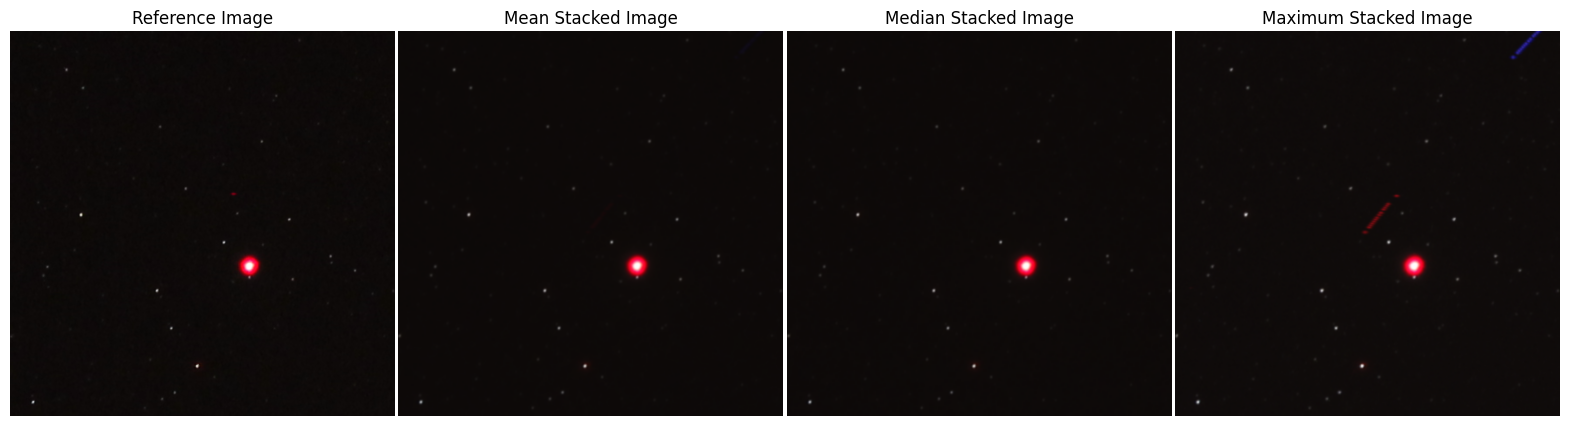

In [15]:
moving_images = [cv2.imread(f"./data/stars_{i:02}.jpg")[1200:2300, 1700:2800, :] for i in range(1, 15)]
reference_image = cv2.imread("./data/stars_00.jpg")[1200:2300, 1700:2800, :]
stacked_images = stack_images(moving_images, reference_image)

images = [zoom_image(stacked_image, 2.5, coord=(400, 350)).astype(int) for stacked_image in (reference_image,) + stacked_images]
titles = ["Reference Image", "Mean Stacked Image", "Median Stacked Image", "Maximum Stacked Image"]
plot_side_by_side(images, titles)

References:
- **AN ASTROPHOTOGRAPHER'S GENTLE INTRODUCTION TO NOISE**. https://skyandtelescope.org/astronomy-blogs/imaging-foundations-richard-wright/astrophotography-gentle-introduction-noise/
- **ASTROPHOTOGRAPHY: STACKING UP YOUR SIGNAL**. https://skyandtelescope.org/astronomy-resources/astrophotography-tips/astrophotography-stacking-signal/
- **Image Quality Factors**. https://www.image-engineering.de/library/image-quality/factors/1080-noise